<a href="https://colab.research.google.com/github/cjzz12345/576_final_project/blob/main/deepEmotion_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read the classes names 

In [1]:
!git config --global user.name "name"
!git config --global user.email "name@email.com"

In [6]:
import os
from getpass import getpass
user = getpass('cjz12345')
password = getpass('31649782qpalzm')
os.environ['GITHUB_AUTH'] = user + ':' + password
#!git clone https://$GITHUB_AUTH@github.com/576_final_project.git
!git clone https://github.com/cjzz12345/576_final_project.git
!git push https://github.com/cjzz12345/576_final_project.git

cjz12345··········
31649782qpalzm··········
fatal: destination path '576_final_project' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [5]:
!git push https://github.com/cjzz12345/576_final_project.git

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!unzip archive


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class Plain_Dataset(Dataset):
    def __init__(self,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
       
        
        self.img_dir = img_dir
        self.transform = transform
        data_dir = img_dir+"/"+datatype
        self.data_info = self.get_img_info(data_dir)
        self.datatype = datatype

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self,idx):
         # 通过 index 读取样本
        path_img, label = self.data_info[idx]
        # 注意这里需要 convert('RGB')
        img = Image.open(path_img).convert('RGB')     # 0~255
        plt.imshow(img)
        plt.show()
        img = Image.open(path_img).convert('L')
        plt.imshow(img,cmap = 'gray')
        plt.show()
        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等
        # 返回是样本和标签
        return img, label
    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        print(data_dir)
        # data_dir 是训练集、验证集或者测试集的路径
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            # dirs ['1', '100']
            j = 0;
            
            for sub_dir in dirs:
                # 文件列表
                img_names = os.listdir(os.path.join(root, sub_dir))
                ff = sub_dir.capitalize()
                print(ff)
                # 取出 jpg 结尾的文件
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
                #img_names = list(filter(lambda x: x.startswith(ff), img_names))
                print(len(img_names))
                # 遍历图片
                num = len(img_names)
              
                for i in range(num):
                    img_name = img_names[i]
                    # 图片的绝对路径
                    path_img = os.path.join(root, sub_dir, img_name)
                    
                    # 标签，这里需要映射为 0、1 两个类别
                    label = j;
                    # 保存在 data_info 变量中
                    data_info.append((path_img, int(label)))
                j = j + 1;
                print(j)
                
        return data_info

#Helper function
def eval_data_dataloader(img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    print(imgg.shape)
    for i in range(dataset.__len__()):
      if (i % 100 == 0):
        img = dataset.__getitem__(i)[0]
        
 
    imgnumpy = imgg.numpy()
    
    imgt = imgnumpy.squeeze()
    #imgt = imgt.reshape(144,48)
    #plt.imshow(imgg)
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3,padding=1)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)
       
        out = F.relu(self.conv1(out))
        out = self.conv2(out)      
        out = F.relu(self.pool2(out))      
        out = F.relu(self.conv3(out))      
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))
        out = F.dropout(out)
        
        
        out = out.view(-1, 810)
        print(5)
        print(out.shape)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        softmax = nn.Softmax(dim=0)
        out = softmax(out)

        return out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion1(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion1,self).__init__()
        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(32,64,3)
        self.conv4 = nn.Conv2d(64,128,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(10368,200)
        self.fc2 = nn.Linear(200,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(3200, 160),
            nn.ReLU(True),
            nn.Linear(160, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 3200)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)
        #out = F.relu(self.conv1(input))
        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 10368)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        softmax = nn.Softmax(dim=0)
        out = softmax(out)

        return out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion2(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion2,self).__init__()
        self.conv1 = nn.Conv2d(1,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.conv41 = nn.Conv2d(128,128,3,padding=1)
        self.pool4 = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)
        self.pool8 = nn.MaxPool2d(2,2)
        self.conv9 = nn.Conv2d(256,512,3,padding=1)
        self.conv10 = nn.Conv2d(512,512,3,padding=1)
        self.conv11 = nn.Conv2d(512,512,3,padding=1)
        self.pool12 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(4608,12)
        self.fc2 = nn.Linear(12,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)


        out = F.relu(self.conv1(out))
        #out = F.relu(self.conv1(out))
        #out = self.conv1(out)
       
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        
        #out = self.conv3(out)
        #out = self.conv4(out)
        out = self.conv41(out)
        #out = self.pool4(out)

        out = F.relu(self.pool4(out))

        #print(1.1)
        #print(out.shape)
        
        out = F.relu(self.conv5(out))
        out = F.relu(self.conv6(out))

        #out = self.conv5(out)
        #out = self.conv6(out)
        #out = self.conv7(out)
        #out = self.pool8(out)

        out = self.norm(self.conv7(out))
        out = F.relu(self.pool8(out))

        #print(1.2)
        #print(out.shape)

        #out = self.conv9(out)
        #out = self.conv10(out)
        #out = self.conv11(out)
        #out = self.pool12(out)

        #out = F.relu(self.conv9(out))
        #out = F.relu(self.conv10(out))
        
        #out = F.relu(self.pool12(out))

        #print(1.3)
        #print(out.shape)

        out = F.dropout(out)


        #print(1.4)
        #print(out.shape)
        out = out.view(-1, 4608)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        softmax = nn.Softmax(dim=0)
        out = softmax(out)

        return out

In [ ]:

def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            
            loss = criterion(outputs,labels)
            loss.backward()
        
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)
            #print(train_correct)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")



In [ ]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 100
lr = 0.005
batchsize = 128

net = Deep_Emotion2()

#net.load_state_dict(torch.load('deep_emotion-500-128-0.005.pt'))
net.to(device)
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#eval_data_dataloader(img_dir = '/content/data', datatype = 'train',sample_number=2789,transform = transformation)
train_dataset= Plain_Dataset(img_dir = '/content/data', datatype = 'train', transform = transformation)
validation_dataset= Plain_Dataset(img_dir = '/content/data', datatype = 'valid', transform = transformation)
train_loader= DataLoader(train_dataset,batch_size=batchsize,shuffle = True)
val_loader= DataLoader(validation_dataset,batch_size=batchsize,shuffle = True)
criterion= nn.CrossEntropyLoss()
optmizer= optim.SGD(net.parameters(),lr=0.005,momentum=0.9)
#optmizer= optim.Adam(net.parameters(),lr= lr)


/content/data/train
Angry
6566
1
Surprise
8113
2
Happy
28592
3
Neutral
29384
4
Disgust
3231
5
Sad
12223
6
Fear
4859
7
/content/data/valid
Angry
1017
1
Surprise
1474
2
Happy
5475
3
Neutral
5839
4
Disgust
656
5
Sad
2236
6
Fear
659
7


/content/data/train
Angry
6566
1
Surprise
8113
2
Happy
28592
3
Neutral
29384
4
Disgust
3231
5
Sad
12223
6
Fear
4859
7


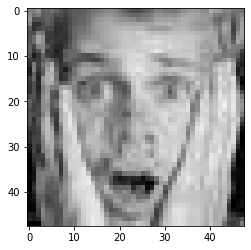

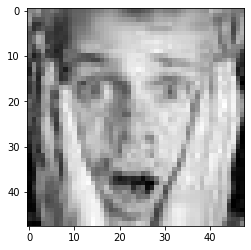

1


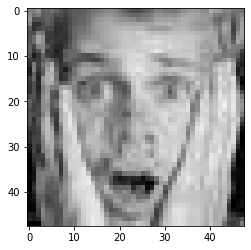

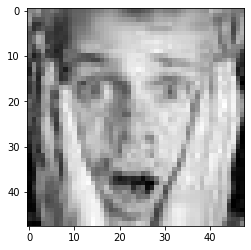

torch.Size([1, 48, 48])


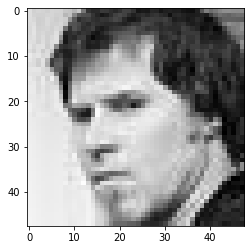

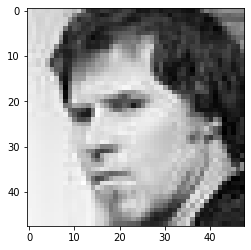

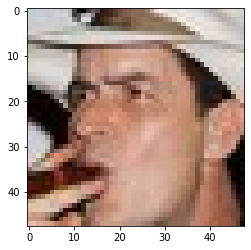

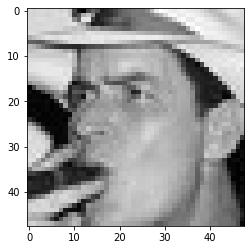

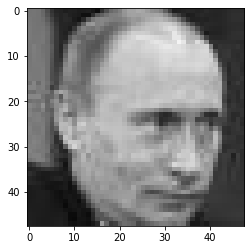

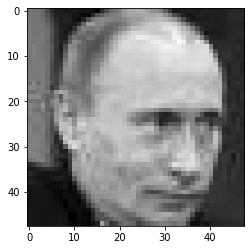

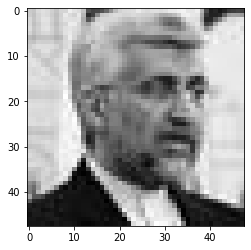

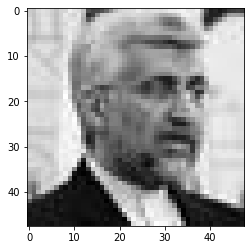

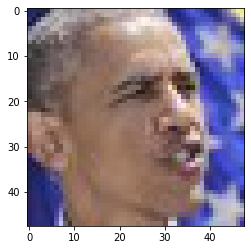

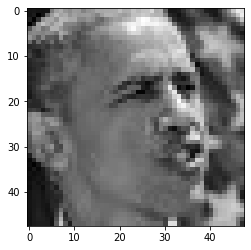

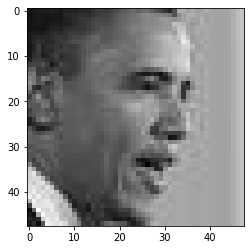

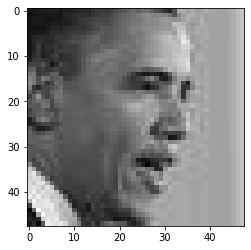

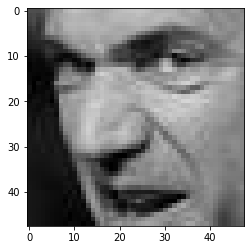

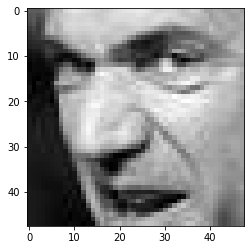

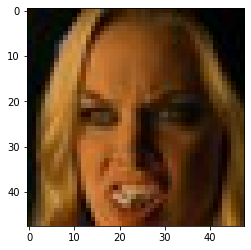

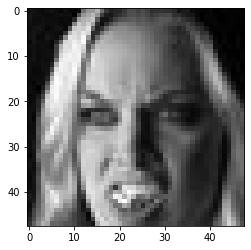

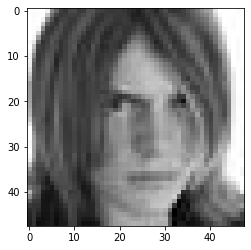

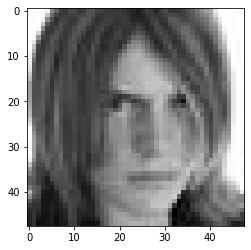

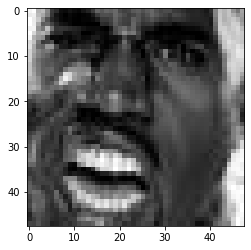

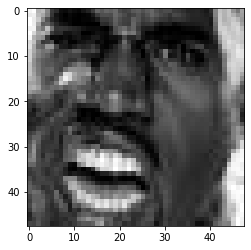

KeyboardInterrupt: ignored

In [ ]:
eval_data_dataloader(img_dir = '/content/data', datatype = 'train',sample_number=10001,transform = transformation)

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01488397 	Validation Loss 0.01506069 	Training Acuuarcy 58.384% 	Validation Acuuarcy 37.543%
Epoch: 2 	Training Loss: 0.01488292 	Validation Loss 0.01504984 	Training Acuuarcy 58.206% 	Validation Acuuarcy 36.777%
Epoch: 3 	Training Loss: 0.01488517 	Validation Loss 0.01505415 	Training Acuuarcy 57.793% 	Validation Acuuarcy 37.589%
Epoch: 4 	Training Loss: 0.01488625 	Validation Loss 0.01505859 	Training Acuuarcy 57.890% 	Validation Acuuarcy 37.255%
Epoch: 5 	Training Loss: 0.01488463 	Validation Loss 0.01506199 	Training Acuuarcy 57.938% 	Validation Acuuarcy 37.382%
Epoch: 6 	Training Loss: 0.01488266 	Validation Loss 0.01505911 	Training Acuuarcy 58.275% 	Validation Acuuarcy 36.996%
Epoch: 7 	Training Loss: 0.01488353 	Validation Loss 0.01505402 	Training Acuuarcy 58.131% 	Validation Acuuarcy 37.307%
Epoch: 8 	Training Loss: 0.01488336 	Validation Loss 0.01505499 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01491405 	Validation Loss 0.01507934 	Training Acuuarcy 50.784% 	Validation Acuuarcy 36.835%
Epoch: 2 	Training Loss: 0.01491089 	Validation Loss 0.01506556 	Training Acuuarcy 50.558% 	Validation Acuuarcy 37.981%
Epoch: 3 	Training Loss: 0.01491060 	Validation Loss 0.01507129 	Training Acuuarcy 50.901% 	Validation Acuuarcy 37.566%
Epoch: 4 	Training Loss: 0.01490963 	Validation Loss 0.01506498 	Training Acuuarcy 50.908% 	Validation Acuuarcy 36.863%
Epoch: 5 	Training Loss: 0.01491330 	Validation Loss 0.01507245 	Training Acuuarcy 50.969% 	Validation Acuuarcy 36.679%
Epoch: 6 	Training Loss: 0.01491039 	Validation Loss 0.01507087 	Training Acuuarcy 51.366% 	Validation Acuuarcy 38.609%
Epoch: 7 	Training Loss: 0.01490737 	Validation Loss 0.01506846 	Training Acuuarcy 51.634% 	Validation Acuuarcy 38.546%
Epoch: 8 	Training Loss: 0.01491059 	Validation Loss 0.01507129 	Training Acuuarcy 51.625% 	Validation Acuuarcy 38.500%
Epoch: 9 	Training Loss: 0.01491048 	Val

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01521585 	Validation Loss 0.01524608 	Training Acuuarcy 18.418% 	Validation Acuuarcy 20.033%
Epoch: 2 	Training Loss: 0.01520630 	Validation Loss 0.01524151 	Training Acuuarcy 19.696% 	Validation Acuuarcy 16.069%
Epoch: 3 	Training Loss: 0.01519632 	Validation Loss 0.01523743 	Training Acuuarcy 19.384% 	Validation Acuuarcy 15.948%
Epoch: 4 	Training Loss: 0.01518489 	Validation Loss 0.01523112 	Training Acuuarcy 19.738% 	Validation Acuuarcy 15.361%
Epoch: 5 	Training Loss: 0.01516370 	Validation Loss 0.01521507 	Training Acuuarcy 19.825% 	Validation Acuuarcy 15.182%
Epoch: 6 	Training Loss: 0.01514013 	Validation Loss 0.01519790 	Training Acuuarcy 19.067% 	Validation Acuuarcy 15.649%
Epoch: 7 	Training Loss: 0.01512308 	Validation Loss 0.01518493 	Training Acuuarcy 19.727% 	Validation Acuuarcy 16.450%
Epoch: 8 	Training Loss: 0.01511084 	Validation Loss 0.01517917 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01521681 	Validation Loss 0.01524797 	Training Acuuarcy 13.653% 	Validation Acuuarcy 13.350%
Epoch: 2 	Training Loss: 0.01521681 	Validation Loss 0.01524797 	Training Acuuarcy 14.055% 	Validation Acuuarcy 13.794%
Epoch: 3 	Training Loss: 0.01521681 	Validation Loss 0.01524797 	Training Acuuarcy 14.727% 	Validation Acuuarcy 14.208%
Epoch: 4 	Training Loss: 0.01521680 	Validation Loss 0.01524797 	Training Acuuarcy 15.496% 	Validation Acuuarcy 15.378%
Epoch: 5 	Training Loss: 0.01521680 	Validation Loss 0.01524797 	Training Acuuarcy 16.562% 	Validation Acuuarcy 15.758%
Epoch: 6 	Training Loss: 0.01521679 	Validation Loss 0.01524796 	Training Acuuarcy 17.455% 	Validation Acuuarcy 16.167%
Epoch: 7 	Training Loss: 0.01521679 	Validation Loss 0.01524796 	Training Acuuarcy 17.967% 	Validation Acuuarcy 16.231%
Epoch: 8 	Training Loss: 0.01521678 	Validation Loss 0.01524796 	Training A

TypeError: ignored

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01521681 	Validation Loss 0.01524796 	Training Acuuarcy 14.646% 	Validation Acuuarcy 14.560%
Epoch: 2 	Training Loss: 0.01521678 	Validation Loss 0.01524795 	Training Acuuarcy 16.572% 	Validation Acuuarcy 16.260%
Epoch: 3 	Training Loss: 0.01521675 	Validation Loss 0.01524794 	Training Acuuarcy 18.563% 	Validation Acuuarcy 17.809%
Epoch: 4 	Training Loss: 0.01521672 	Validation Loss 0.01524791 	Training Acuuarcy 20.877% 	Validation Acuuarcy 19.319%
Epoch: 5 	Training Loss: 0.01521666 	Validation Loss 0.01524788 	Training Acuuarcy 22.210% 	Validation Acuuarcy 20.644%
Epoch: 6 	Training Loss: 0.01521658 	Validation Loss 0.01524783 	Training Acuuarcy 23.366% 	Validation Acuuarcy 21.555%
Epoch: 7 	Training Loss: 0.01521647 	Validation Loss 0.01524776 	Training Acuuarcy 24.170% 	Validation Acuuarcy 21.566%
Epoch: 8 	Training Loss: 0.01521630 	Validation Loss 0.01524766 	Training A

KeyboardInterrupt: ignored

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03049372 	Validation Loss 0.03076693 	Training Acuuarcy 19.071% 	Validation Acuuarcy 19.755%
Epoch: 2 	Training Loss: 0.03037422 	Validation Loss 0.03091617 	Training Acuuarcy 22.107% 	Validation Acuuarcy 18.204%
Epoch: 3 	Training Loss: 0.03034156 	Validation Loss 0.03080955 	Training Acuuarcy 22.357% 	Validation Acuuarcy 20.204%
Epoch: 4 	Training Loss: 0.03024558 	Validation Loss 0.03075158 	Training Acuuarcy 22.786% 	Validation Acuuarcy 20.735%
Epoch: 5 	Training Loss: 0.03035974 	Validation Loss 0.03084432 	Training Acuuarcy 20.393% 	Validation Acuuarcy 17.796%
Epoch: 6 	Training Loss: 0.03026278 	Validation Loss 0.03078650 	Training Acuuarcy 21.929% 	Validation Acuuarcy 20.286%
Epoch: 7 	Training Loss: 0.03026528 	Validation Loss 0.03078539 	Training Acuuarcy 22.250% 	Validation Acuuarcy 21.592%
Epoch: 8 	Training Loss: 0.03019202 	Validation Loss 0.03070095 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size 2000 /50  lr =0.005  optimizer = SGD  with more filters(feature map)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01532735 	Validation Loss 0.01567725 	Training Acuuarcy 19.025% 	Validation Acuuarcy 22.792%
Epoch: 2 	Training Loss: 0.01530425 	Validation Loss 0.01567700 	Training Acuuarcy 22.941% 	Validation Acuuarcy 24.575%
Epoch: 3 	Training Loss: 0.01527568 	Validation Loss 0.01560742 	Training Acuuarcy 22.145% 	Validation Acuuarcy 23.461%
Epoch: 4 	Training Loss: 0.01525866 	Validation Loss 0.01563846 	Training Acuuarcy 20.762% 	Validation Acuuarcy 21.427%
Epoch: 5 	Training Loss: 0.01523191 	Validation Loss 0.01554507 	Training Acuuarcy 20.803% 	Validation Acuuarcy 21.399%
Epoch: 6 	Training Loss: 0.01521926 	Validation Loss 0.01560201 	Training Acuuarcy 20.634% 	Validation Acuuarcy 20.702%
Epoch: 7 	Training Loss: 0.01519654 	Validation Loss 0.01561627 	Training Acuuarcy 21.140% 	Validation Acuuarcy 20.117%
Epoch: 8 	Training Loss: 0.01518333 	Validation Loss 0.01559112 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)


===================================Start Training===================================
Epoch: 1 	Training Loss: 0.02991295 	Validation Loss 0.03061174 	Training Acuuarcy 30.714% 	Validation Acuuarcy 24.531%
Epoch: 2 	Training Loss: 0.02991470 	Validation Loss 0.03057169 	Training Acuuarcy 30.607% 	Validation Acuuarcy 24.735%
Epoch: 3 	Training Loss: 0.02988107 	Validation Loss 0.03058217 	Training Acuuarcy 31.357% 	Validation Acuuarcy 24.163%
Epoch: 4 	Training Loss: 0.02989054 	Validation Loss 0.03056869 	Training Acuuarcy 31.679% 	Validation Acuuarcy 24.571%
Epoch: 5 	Training Loss: 0.02990355 	Validation Loss 0.03053627 	Training Acuuarcy 31.036% 	Validation Acuuarcy 24.735%
Epoch: 6 	Training Loss: 0.02986915 	Validation Loss 0.03060407 	Training Acuuarcy 31.179% 	Validation Acuuarcy 25.102%
Epoch: 7 	Training Loss: 0.02983787 	Validation Loss 0.03062717 	Training Acuuarcy 31.571% 	Validation Acuuarcy 23.306%
Epoch: 8 	Training Loss: 0.02986378 	Validation Loss 0.03058308 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size 2000 /50  lr =0.01  optimizer = SGD  with more filters(feature map)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01531979 	Validation Loss 0.01568821 	Training Acuuarcy 20.947% 	Validation Acuuarcy 27.529%
Epoch: 2 	Training Loss: 0.01527024 	Validation Loss 0.01564076 	Training Acuuarcy 22.958% 	Validation Acuuarcy 22.736%
Epoch: 3 	Training Loss: 0.01523245 	Validation Loss 0.01556403 	Training Acuuarcy 21.180% 	Validation Acuuarcy 20.033%
Epoch: 4 	Training Loss: 0.01520437 	Validation Loss 0.01550524 	Training Acuuarcy 20.344% 	Validation Acuuarcy 22.541%
Epoch: 5 	Training Loss: 0.01517003 	Validation Loss 0.01559289 	Training Acuuarcy 23.569% 	Validation Acuuarcy 22.541%
Epoch: 6 	Training Loss: 0.01515415 	Validation Loss 0.01558912 	Training Acuuarcy 25.346% 	Validation Acuuarcy 24.296%
Epoch: 7 	Training Loss: 0.01513982 	Validation Loss 0.01546733 	Training Acuuarcy 25.788% 	Validation Acuuarcy 25.160%
Epoch: 8 	Training Loss: 0.01513392 	Validation Loss 0.01557300 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size all  lr =0.01  optimizer = SGD  with more filters(feature map)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01521039 	Validation Loss 0.01560831 	Training Acuuarcy 22.352% 	Validation Acuuarcy 20.981%
Epoch: 2 	Training Loss: 0.01512484 	Validation Loss 0.01550699 	Training Acuuarcy 18.510% 	Validation Acuuarcy 18.278%
Epoch: 3 	Training Loss: 0.01509824 	Validation Loss 0.01554677 	Training Acuuarcy 17.998% 	Validation Acuuarcy 17.749%
Epoch: 4 	Training Loss: 0.01507972 	Validation Loss 0.01547924 	Training Acuuarcy 17.402% 	Validation Acuuarcy 16.411%
Epoch: 5 	Training Loss: 0.01507078 	Validation Loss 0.01558258 	Training Acuuarcy 20.109% 	Validation Acuuarcy 19.588%
Epoch: 6 	Training Loss: 0.01505969 	Validation Loss 0.01550230 	Training Acuuarcy 20.196% 	Validation Acuuarcy 18.139%
Epoch: 7 	Training Loss: 0.01504520 	Validation Loss 0.01553203 	Training Acuuarcy 21.495% 	Validation Acuuarcy 19.866%
Epoch: 8 	Training Loss: 0.01504228 	Validation Loss 0.01544095 	Training A

KeyboardInterrupt: ignored

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size all all  lr =0.005  optimizer = SGD  with more filters(feature map) no localization network

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01520300 	Validation Loss 0.01522898 	Training Acuuarcy 24.923% 	Validation Acuuarcy 22.407%
Epoch: 2 	Training Loss: 0.01514619 	Validation Loss 0.01519200 	Training Acuuarcy 24.520% 	Validation Acuuarcy 18.380%
Epoch: 3 	Training Loss: 0.01511009 	Validation Loss 0.01517208 	Training Acuuarcy 21.923% 	Validation Acuuarcy 17.014%
Epoch: 4 	Training Loss: 0.01509341 	Validation Loss 0.01516541 	Training Acuuarcy 20.955% 	Validation Acuuarcy 17.579%
Epoch: 5 	Training Loss: 0.01508362 	Validation Loss 0.01515691 	Training Acuuarcy 21.317% 	Validation Acuuarcy 17.786%
Epoch: 6 	Training Loss: 0.01507379 	Validation Loss 0.01515359 	Training Acuuarcy 20.922% 	Validation Acuuarcy 18.028%
Epoch: 7 	Training Loss: 0.01506418 	Validation Loss 0.01513934 	Training Acuuarcy 21.383% 	Validation Acuuarcy 17.786%
Epoch: 8 	Training Loss: 0.01505849 	Validation Loss 0.01514042 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size all all  lr =0.01  optimizer = SGD  with more filters(feature map) with localization network

===================================Start Training===================================


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01518063 	Validation Loss 0.01520721 	Training Acuuarcy 22.720% 	Validation Acuuarcy 15.245%
Epoch: 2 	Training Loss: 0.01511498 	Validation Loss 0.01517025 	Training Acuuarcy 18.657% 	Validation Acuuarcy 14.352%
Epoch: 3 	Training Loss: 0.01509509 	Validation Loss 0.01515921 	Training Acuuarcy 17.934% 	Validation Acuuarcy 15.436%
Epoch: 4 	Training Loss: 0.01508249 	Validation Loss 0.01516139 	Training Acuuarcy 18.290% 	Validation Acuuarcy 16.375%
Epoch: 5 	Training Loss: 0.01507289 	Validation Loss 0.01514251 	Training Acuuarcy 18.618% 	Validation Acuuarcy 17.366%
Epoch: 6 	Training Loss: 0.01506764 	Validation Loss 0.01514130 	Training Acuuarcy 21.055% 	Validation Acuuarcy 19.083%
Epoch: 7 	Training Loss: 0.01505921 	Validation Loss 0.01514070 	Training Acuuarcy 21.899% 	Validation Acuuarcy 19.636%
Epoch: 8 	Training Loss: 0.01505812 	Validation Loss 0.01513900 	Training Acuuarcy 22.978% 	Validation Acuuarcy 19.855%
Epoch: 9 	Training Loss: 0.01505240 	Val

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size all all  lr =0.01  optimizer = SGD  with more filters(feature map) with localization network epoch = 500

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01518142 	Validation Loss 0.01520343 	Training Acuuarcy 23.787% 	Validation Acuuarcy 17.769%
Epoch: 2 	Training Loss: 0.01511224 	Validation Loss 0.01517788 	Training Acuuarcy 20.682% 	Validation Acuuarcy 16.778%
Epoch: 3 	Training Loss: 0.01509240 	Validation Loss 0.01516872 	Training Acuuarcy 18.805% 	Validation Acuuarcy 14.456%
Epoch: 4 	Training Loss: 0.01508259 	Validation Loss 0.01515537 	Training Acuuarcy 18.436% 	Validation Acuuarcy 14.779%
Epoch: 5 	Training Loss: 0.01507419 	Validation Loss 0.01515711 	Training Acuuarcy 18.852% 	Validation Acuuarcy 16.357%
Epoch: 6 	Training Loss: 0.01506572 	Validation Loss 0.01514128 	Training Acuuarcy 20.305% 	Validation Acuuarcy 18.921%
Epoch: 7 	Training Loss: 0.01505850 	Validation Loss 0.01515006 	Training Acuuarcy 21.219% 	Validation Acuuarcy 17.729%
Epoch: 8 	Training Loss: 0.01505735 	Validation Loss 0.01512693 	Training A

In [ ]:
Train(epochs, train_loader, val_loader, criterion, optmizer, device)
#batch = 128  size all all  lr =0.01  optimizer = SGD  with more filters(feature map) with localization network epoch = 500

===================================Start Training===================================


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01489080 	Validation Loss 0.01505488 	Training Acuuarcy 54.968% 	Validation Acuuarcy 36.039%
Epoch: 2 	Training Loss: 0.01489044 	Validation Loss 0.01505644 	Training Acuuarcy 55.469% 	Validation Acuuarcy 36.535%
Epoch: 3 	Training Loss: 0.01489368 	Validation Loss 0.01505804 	Training Acuuarcy 55.196% 	Validation Acuuarcy 35.688%
Epoch: 4 	Training Loss: 0.01489453 	Validation Loss 0.01506869 	Training Acuuarcy 54.789% 	Validation Acuuarcy 34.357%
Epoch: 5 	Training Loss: 0.01489424 	Validation Loss 0.01505226 	Training Acuuarcy 54.627% 	Validation Acuuarcy 35.780%
Epoch: 6 	Training Loss: 0.01489146 	Validation Loss 0.01505476 	Training Acuuarcy 54.646% 	Validation Acuuarcy 36.927%
Epoch: 7 	Training Loss: 0.01489140 	Validation Loss 0.01506555 	Training Acuuarcy 55.432% 	Validation Acuuarcy 35.118%
Epoch: 8 	Training Loss: 0.01489253 	Validation Loss 0.01506270 	Training Acuuarcy 55.210% 	Validation Acuuarcy 36.143%
Epoch: 9 	Training Loss: 0.01489255 	Val